In [1]:
import EWS_functions as ews
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Ordinary Least Squares

Consider the the following linear regression model:

$$ 
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix} 
= 
\begin{bmatrix}
1 & x_{12} & x_{13} & \ldots & x_{1p} \\ 
1 & x_{21} & x_{23} & \ldots & x_{2p} \\
\vdots & \vdots & \vdots \\
1 & x_{n1} & x_{n3} & \ldots & x_{np} \\
\end{bmatrix} 
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_p \\
\end{bmatrix} 
+ 
\begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n \\
\end{bmatrix} 
$$

This can also be written as:

$$\mathbf{y} = X\mathbf{\beta} + \mathbf{\epsilon}$$

In order to apply the [Ordinary Least Squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimator, the following assumptions are made about the error terms $\mathbf{\epsilon}$ according to the Gauss-Markov Theorem:

- $\mathbb{E}(\mathbf{\epsilon}_i) = 0 \quad \forall i = 1, \ldots, n$ (errors have zero mean)
- Var$(\mathbf{\epsilon}_i) = \sigma^2 \quad \forall i = 1, \ldots, n$ (errors have constant variance)
- Cov$(\mathbf{\epsilon}_i, \mathbf{\epsilon}_j) = 0 \quad \forall i \neq j$ (errors are uncorrelated)

Hence the covariance matrix of the error terms is given by:

$$ \Omega = \sigma^2I $$

This is also known as the homoscedacity condition.
If the above assumptions are true, then an unbised estimator of $\hat{\mathbf{\beta}}$ is calculated using OLS:

$$ \hat{\mathbf{\beta}}_{OLS} = arg min_{\mathbf{b}}\left[(\mathbf{y} - X\mathbf{b})^T(\mathbf{y} - X\mathbf{b})\right]$$

or equivalently

$$ \hat{\mathbf{\beta}}_{OLS} = (X^TX)^{-1}X^T\mathbf{y} $$

# Generalised Least Squares

Suppose instead, heteroscedacity is assumed:

$$ \Omega \neq \sigma^2I $$

Hence the variance of errors can be non-constant and there may be correlation between errors. If this is the case then [Generalised Least Squares (GLS)](https://en.wikipedia.org/wiki/Generalized_least_squares) is used to calculate the unbiased estimator:

$$ \hat{\mathbf{\beta}}_{GLS} = arg min_{\mathbf{b}}\left[(\mathbf{y} - X\mathbf{b})^T\Omega^{-1}(\mathbf{y} - X\mathbf{b})\right]$$

or equivalently:

$$ \hat{\mathbf{\beta}}_{GLS} = (X^T\Omega^{-1}X)^{-1}X^T\Omega^{-1}\mathbf{y} $$

## First Order Autoregressive Variance Structure

$$ 
\Omega = \sigma^2
\begin{bmatrix}
1 & \rho & \rho^2 & \rho^3 \\
\rho & 1 & \rho & \rho^2 \\
\rho^2 & \rho & 1 & \rho \\
\rho^3 & \rho^2 & \rho & 1 \\
\end{bmatrix}
$$

This is the covariance structure used by the [GLSAR](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.GLSAR.html). It assumes that the variance is constant and the errors are lag-1 auto-correlated. The estimates for $\sigma$ and $\rho$ are calculated by solving the [Yule-Walker equations](https://en.wikipedia.org/wiki/Autoregressive_moving_average_model):

$$ \gamma_m = \Sigma_{k=1}^{p} \rho_k \gamma_{m-k} + \sigma_\epsilon^2\delta_{m,0}, \quad m = 0,\ldots,p$$

For first order auto-correlation $(p = 1)$ this gives two equations:


$$ 
\begin{align}
\gamma_0 &= \rho_1\gamma_{-1} + \sigma_\epsilon^2 \\
\gamma_1 &= \rho_1\gamma_0 
\end{align}
$$

Hence:

$$ 
\begin{align}
\rho_1 &= \frac{\gamma_1}{\gamma_0} \\
\sigma_\epsilon^2 &= \gamma_1 - \rho_1\gamma_{-1} 
\end{align}
$$

In [58]:
# simulation parameters
dt = 0.01
tmax = 100
n = int(tmax / dt)
t = np.linspace(0.0, tmax, n)

steps = np.arange(0, n)

## Model 1

The following model approches a critical transition:

$$ \dot{x} = -x^3 + x - T + \eta(t)$$

- $\eta(t)$ is white noise with standard deviation $\sigma$ = 0.2.
- $T$ is linearly increasing from -1 to 1.

This system destabalises once $T > \frac{2}{3\sqrt{3}}$ when no noise is present. This model can be simulated using the [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler-Maruyama_method) for stochastic differential equations:

$$ x_{i+1} = x_{i} + (-x_i^3 + x_i - T(t_i))\Delta t + \sigma dW$$ 

- dW is a normally distributed value with expected value $\mu = 0$ and variance $\sigma^2 = \Delta t$.

(-1.55, 1.55)

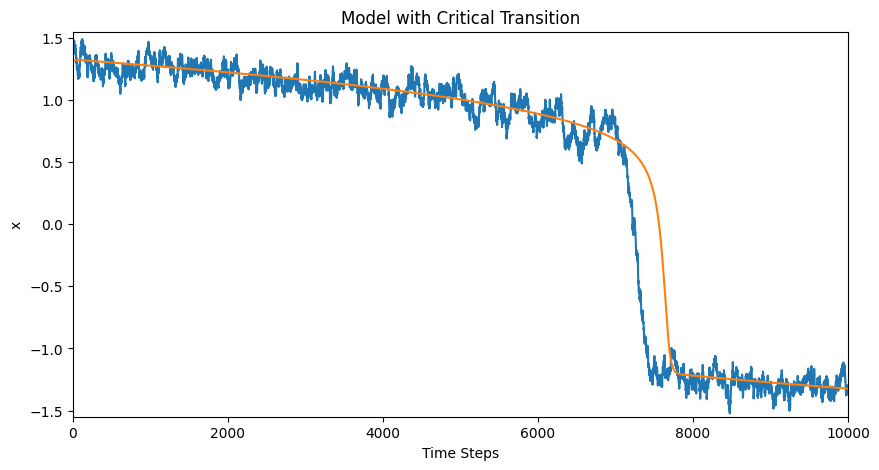

In [59]:
# parameters
sigma = 0.2
T = 2 * t / tmax - 1

# initialise time series
model1 = np.zeros(n)
model1_noisy = np.zeros(n)
model1[0] = model1_noisy[0] = 1.31 # initial value (close to equilibrium for T = -1)

# Euler-Maruyama method
np.random.seed(0)
for i in range(n - 1):
    model1_noisy[i + 1] = model1_noisy[i] + dt * (-model1_noisy[i]**3 + model1_noisy[i] - T[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(dt))

for i in range(n - 1):
    model1[i + 1] = model1[i] + dt * (-model1[i]**3 + model1[i] - T[i])

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set_title('Model with Critical Transition')
ax.plot(steps, model1_noisy)
ax.plot(steps, model1)
ax.vlines(70000, -1.55, 1.55, 'r')
ax.set_xlim(0, n)
ax.set_xlabel('Time Steps')
ax.set_ylabel('x')
ax.set_ylim(-1.55, 1.55)

## Model 2

The following model does not have a critical transition:

$$ \dot{x} = -5x + \eta(t)$$

- $\eta(t)$ is auto-correlated noise.
- The standard deviation $\sigma$ is increasing linearly from 0.2 to 1.0.
- The AR(1) coefficient is increasing linearly from 0.1 to 0.95.

This model can be simulated using the Euler-Maruyama method:

$$ x_{t+1} = x_t + (-5x_t)\Delta t + \sigma dW $$

- dW is an auto-correlated signal with expected value $\mu = 0$ and variance $\sigma^2 = \Delta t$.

(0.0, 10000.0)

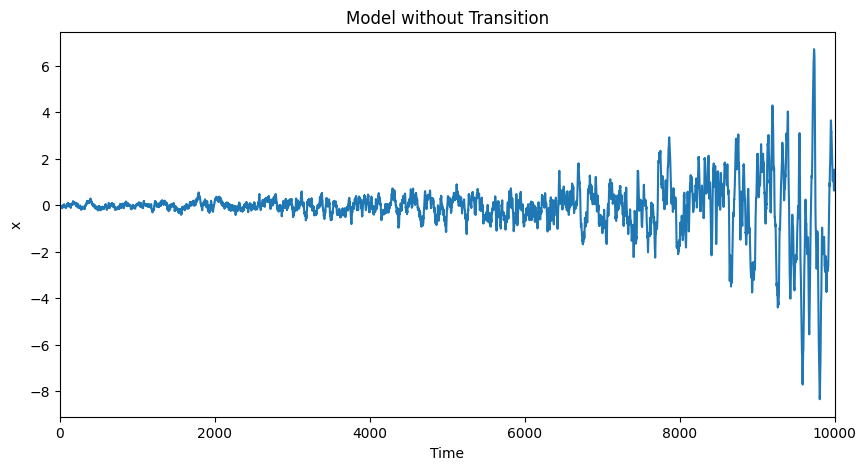

In [60]:
# auto-correlated noise generator
def lag1_signal(n, phi, sigma):
    sigma_e = np.sqrt((sigma**2) * (1 - phi**2))
    
    signal = np.zeros(n)
    signal[0] = np.random.normal(loc=0.0, scale=sigma_e[0])
    
    for i in range(n - 1):
        signal[i + 1] = phi[i] * signal[i] + np.random.normal(loc=0.0, scale=np.sqrt(sigma_e[0]))

    return signal

# parameters
sigma = 0.8 * t / tmax + 0.2 
phi = 0.85 * t / tmax + 0.1
np.random.seed(2)
signal = lag1_signal(n, phi=phi, sigma=dt)

# initialize model
model2 = np.zeros(n)
model2[0] = signal[0]

# Euler-Maruyama method
for i in range(n - 1):
    model2[i + 1] = model2[i] + dt * -5 * model2[i] + sigma[i] * signal[i + 1]
    
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set_title('Model without Transition')
ax.plot(steps, model2)
ax.set_xlabel('Time')
ax.set_ylabel('x')
ax.set_xlim(0, n)

Calculate moving averages and linear fits.

In [23]:
# domain parameters
w = 2000 # window size
bound = 1000
transition_point = 7000
indices1 = slice(bound, transition_point-bound)
indices2 = slice(bound, -bound)

tt_samples = 10_000
np.random.seed(0)
# variance
model1_var = ews.runstd(model1_noisy, w)**2
p0, p1 = np.polyfit(steps[indices1], model1_var[indices1], 1)
model1_var_fit = p0 * steps[indices1] + p1
model1_var_pv = ews.kendall_tau_test(model1_var[indices1], tt_samples, p0)

model2_var = ews.runstd(model2, w)**2
p0, p1 = np.polyfit(steps[indices2], model2_var[indices2], 1)
model2_var_fit = p0 * steps[indices2] + p1
model2_var_pv = ews.kendall_tau_test(model2_var[indices2], tt_samples, p0)

# auto-correlation
model1_ac = ews.runac(model1_noisy, w)
p0, p1 = np.polyfit(steps[indices1], model1_ac[indices1], 1)
model1_ac_fit = p0 * steps[indices1] + p1
model1_ac_pv = ews.kendall_tau_test(model1_ac[indices1], tt_samples, p0)

model2_ac = ews.runac(model2, w)
p0, p1 = np.polyfit(steps[indices2], model2_ac[indices2], 1)
model2_ac_fit = p0 * steps[indices2] + p1
model2_ac_pv = ews.kendall_tau_test(model2_ac[indices2], tt_samples, p0)

# restoring rate
model1_a = ews.run_fit_a(model1_noisy, w)
p0, p1 = np.polyfit(steps[indices1], model1_a[indices1], 1)
model1_a_fit = p0 * steps[indices1] + p1
model1_a_pv = ews.kendall_tau_test(model1_a[indices1], tt_samples, p0)

model1_a_ar1 = ews.run_fit_a_ar1(model1_noisy, w)
p0, p1 = np.polyfit(steps[indices1], model1_a_ar1[indices1], 1)
model1_a_ar1_fit = p0 * steps[indices1] + p1
model1_a_ar1_pv = ews.kendall_tau_test(model1_a_ar1[indices1], tt_samples, p0)

model2_a = ews.run_fit_a(model2, w)
p0, p1 = np.polyfit(steps[indices2], model2_a[indices2], 1)
model2_a_fit = p0 * steps[indices2] + p1
model2_a_pv = ews.kendall_tau_test(model2_a[indices2], tt_samples, p0)

model2_a_ar1 = ews.run_fit_a_ar1(model2, w)
p0, p1 = np.polyfit(steps[indices2], model2_a_ar1[indices2], 1)
model2_a_ar1_fit = p0 * steps[indices2] + p1
model2_a_ar1_pv = ews.kendall_tau_test(model2_a_ar1[indices2], tt_samples, p0)

MemoryError: Unable to allocate 5.07 GiB for an array with shape (10000, 34001) and data type complex128

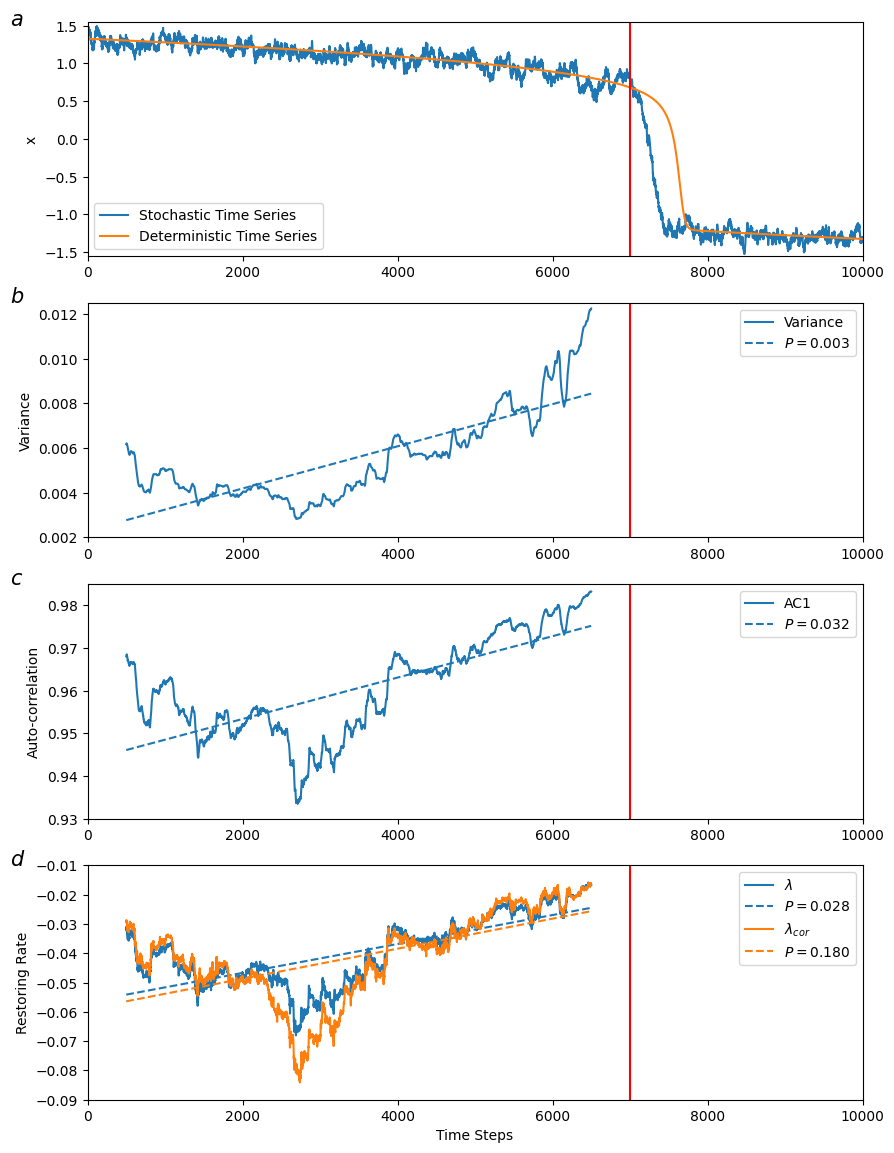

In [11]:
fig = plt.figure(figsize=(10, 14))

time = np.arange(0, n)

# model
ax = fig.add_subplot(411)
ax.text(-1000, 1.5, '$a$', fontsize=15, weight='bold')
ax.plot(steps, model1_noisy, label='Stochastic Time Series')
ax.plot(steps, model1, label='Deterministic Time Series')
ax.vlines(transition_point, -1.55, 1.55, 'r')
ax.set_ylabel('x')
ax.set_xlim(0, n)
ax.set_ylim(-1.55, 1.55)
ax.legend()

# variance
ax = fig.add_subplot(412)
ax.text(-1000, 0.0125, '$b$', fontsize=15, weight='bold')
ax.plot(steps[indices1], model1_var[indices1], label='Variance')
ax.plot(steps[indices1], model1_var_fit, color='tab:blue', linestyle='--', label=f"$P = {model1_var_pv:.3f}$")
ax.vlines(transition_point, -1.55, 1.55, 'r')
ax.set_ylabel('Variance')
ax.set_xlim(0, n)
ax.set_ylim(0.002, 0.0125)
ax.legend()

# auto-correlation
ax = fig.add_subplot(413)
ax.text(-1000, 0.985, '$c$', fontsize=15, weight='bold')
ax.plot(steps[indices1], model1_ac[indices1], label='AC1')
ax.plot(steps[indices1], model1_ac_fit, color='tab:blue', linestyle='--', label=f"$P = {model1_ac_pv:.3f}$")
ax.vlines(transition_point, -1.55, 1.55, 'r')
ax.set_ylabel('Auto-correlation')
ax.set_xlim(0, n)
ax.set_ylim(0.93, 0.985)
ax.legend()

# restoring rate
ax = fig.add_subplot(414)
ax.text(-1000, -0.01, '$d$', fontsize=15, weight='bold')
ax.plot(steps[indices1], model1_a[indices1], label='$\lambda$')
ax.plot(steps[indices1], model1_a_fit, color='tab:blue', linestyle='--', label=f"$P = {model1_a_pv:.3f}$")
ax.plot(steps[indices1], model1_a_ar1[indices1], label='$\lambda_{cor}$')
ax.plot(steps[indices1], model1_a_ar1_fit, color='tab:orange', linestyle='--', label=f"$P = {model1_a_ar1_pv:.3f}$")
ax.vlines(transition_point, -1.55, 1.55, 'r')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Restoring Rate')
ax.set_xlim(0, n)
ax.set_ylim(-0.09, -0.01)
ax.legend()



In [12]:
fig.savefig(f"plots/model_with_critical_transition_{dt}_{tmax}_{n}_{w}.pdf")
#fig.savefig(f"plots/model_with_critical_transition.pdf")

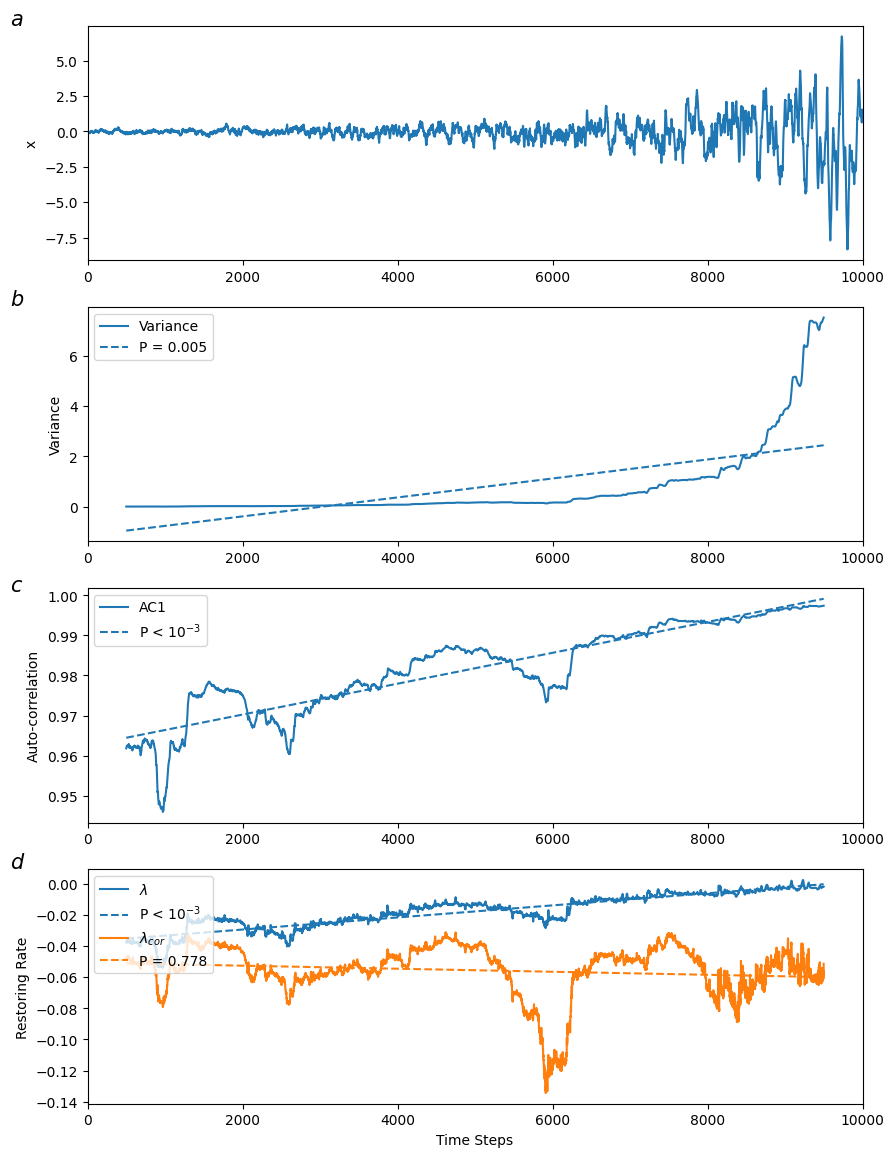

In [17]:
fig = plt.figure(figsize=(10, 14))

# model
ax = fig.add_subplot(411)
ax.text(-1000, 7.5, '$a$', fontsize=15, weight='bold')
ax.plot(steps, model2)
ax.set_ylabel('x')
ax.set_xlim(0, n)
#ax.legend()

# variance
ax = fig.add_subplot(412)
ax.text(-1000, 8, '$b$', fontsize=15, weight='bold')
ax.plot(steps[indices2], model2_var[indices2], label='Variance')
ax.plot(steps[indices2], model2_var_fit, color='tab:blue', linestyle='--', label=f"P = {model2_var_pv:.3f}")
ax.set_ylabel('Variance')
ax.set_xlim(0, n)
ax.legend()

# auto-correlation
ax = fig.add_subplot(4, 1, 3)
ax.text(-1000, 1.001, '$c$', fontsize=15, weight='bold')
ax.plot(steps[indices2], model2_ac[indices2], label='AC1')
ax.plot(steps[indices2], model2_ac_fit, color='tab:blue', linestyle='--', label="P < $10^{-3}$")
ax.set_ylabel('Auto-correlation')
ax.set_xlim(0, n)
ax.legend()

# restoring rate
ax = fig.add_subplot(4, 1, 4)
ax.text(-1000, 0.01, '$d$', fontsize=15, weight='bold')
ax.plot(steps[indices2], model2_a[indices2], label='$\lambda$')
ax.plot(steps[indices2], model2_a_fit, color='tab:blue', linestyle='--', label="P < $10^{-3}$")
ax.plot(steps[indices2], model2_a_ar1[indices2], label='$\lambda_{cor}$')
ax.plot(steps[indices2], model2_a_ar1_fit, color='tab:orange', linestyle='--', label=f"P = {model2_a_ar1_pv:.3f}")
ax.set_xlabel('Time Steps')
ax.set_ylabel('Restoring Rate')
ax.set_xlim(0, n)
ax.legend(loc='upper left')

In [18]:
fig.savefig(f"plots/model_without_transition_{dt}_{tmax}_{n}_{w}.pdf")
#fig.savefig(f"plots/model_without_transition.pdf")

# Changing the Parameters

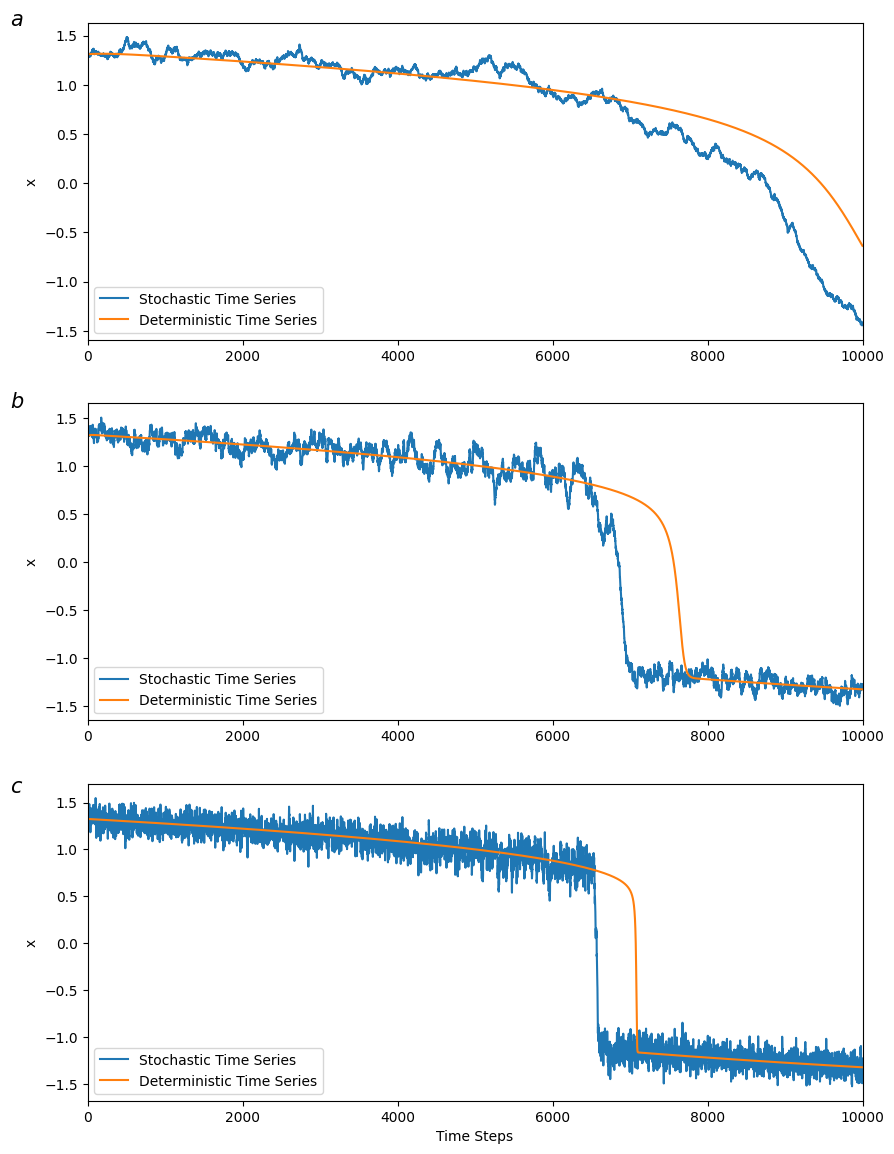

In [121]:
# parameters
sigma = 0.2
T = 2 * t / tmax - 1


# initialise time series
model1_10 = np.zeros(n)
model1_10_noisy = np.zeros(n)
model1_10[0] = model1_10_noisy[0] = 1.31 # initial value (close to equilibrium for T = -1)

model1_100 = model1_10.copy()
model1_1000 = model1_10.copy()
model1_100_noisy = model1_10_noisy.copy()
model1_1000_noisy = model1_10_noisy.copy()

# Euler-Maruyama method
np.random.seed(1)
for i in range(n - 1):
    model1_10_noisy[i + 1] = model1_10_noisy[i] + 0.001 * (-model1_10_noisy[i]**3 + model1_10_noisy[i] - T[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(0.001))
    model1_100_noisy[i + 1] = model1_100_noisy[i] + 0.01 * (-model1_100_noisy[i]**3 + model1_100_noisy[i] - T[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(0.01))
    model1_1000_noisy[i + 1] = model1_1000_noisy[i] + 0.1 * (-model1_1000_noisy[i]**3 + model1_1000_noisy[i] - T[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(0.1))
for i in range(n - 1):
    model1_10[i + 1] = model1_10[i] + 0.001 * (-model1_10[i]**3 + model1_10[i] - T[i])
    model1_100[i + 1] = model1_100[i] + 0.01 * (-model1_100[i]**3 + model1_100[i] - T[i])
    model1_1000[i + 1] = model1_1000[i] + 0.1 * (-model1_1000[i]**3 + model1_1000[i] - T[i])
    
fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(311)
ax.text(-1000, 1.6, '$a$', fontsize=15, weight='bold')
ax.plot(steps, model1_10_noisy, label="Stochastic Time Series")
ax.plot(steps, model1_10, label="Deterministic Time Series")
ax.set_ylabel('x')
ax.set_xlim(0, 10000)
ax.legend(loc='lower left')

ax = fig.add_subplot(312)
ax.text(-1000, 1.6, '$b$', fontsize=15, weight='bold')
ax.plot(steps, model1_100_noisy, label="Stochastic Time Series")
ax.plot(steps, model1_100, label="Deterministic Time Series")
ax.set_ylabel('x')
ax.set_xlim(0, 10000)
ax.legend(loc='lower left')

ax = fig.add_subplot(313)
ax.text(-1000, 1.6, '$c$', fontsize=15, weight='bold')
ax.plot(steps, model1_1000_noisy, label="Stochastic Time Series")
ax.plot(steps, model1_1000, label="Deterministic Time Series")
ax.set_ylabel('x')
ax.set_xlabel("Time Steps")
ax.set_xlim(0, 10000)
ax.legend(loc='lower left')

In [122]:
fig.savefig(f"plots/model_with_critical_transition_timescale_comparison.pdf")

(0.0, 10000.0)

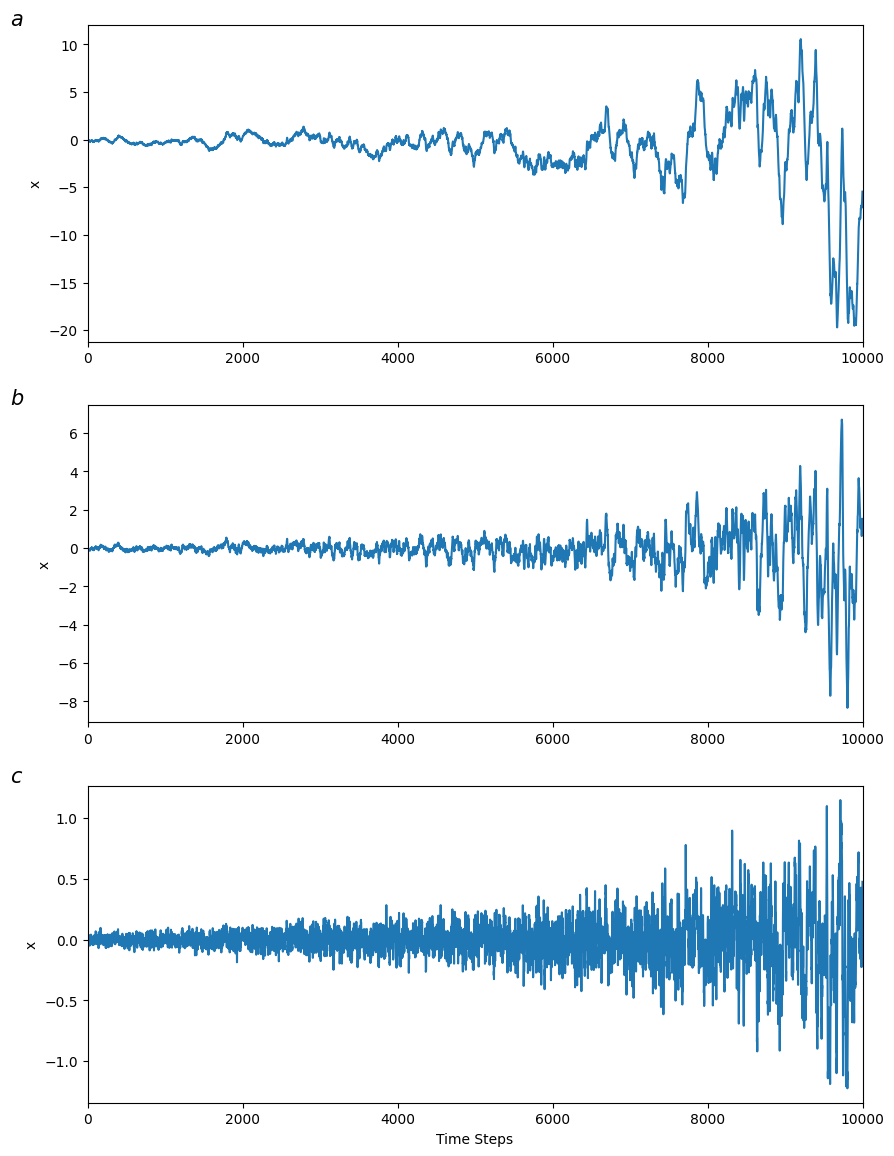

In [123]:
# parameters
sigma = 0.8 * t / tmax + 0.2 
phi = 0.85 * t / tmax + 0.1
np.random.seed(0)
signal_10 = lag1_signal(n, phi=phi, sigma=0.001)
signal_100 = lag1_signal(n, phi=phi, sigma=0.01)
signal_1000 = lag1_signal(n, phi=phi, sigma=0.1)

# initialize model
model2_10 = np.zeros(n)
model2_10[0] = signal[0]

model2_100 = model2_10.copy()
model2_1000 = model2_10.copy()

# Euler-Maruyama method
for i in range(n - 1):
    model2_10[i + 1] = model2_10[i] + 0.001 * -5 * model2_10[i] + sigma[i] * signal[i + 1]
    model2_100[i + 1] = model2_100[i] + 0.01 * -5 * model2_100[i] + sigma[i] * signal[i + 1]
    model2_1000[i + 1] = model2_1000[i] + 0.1 * -5 * model2_1000[i] + sigma[i] * signal[i + 1]
    
fig = plt.figure(figsize=(10,14))

ax = fig.add_subplot(311)
ax.text(-1000, 12, '$a$', fontsize=15, weight='bold')
ax.plot(steps, model2_10)
ax.set_ylabel('x')
ax.set_xlim(0, n)

ax = fig.add_subplot(312)
ax.text(-1000, 7.5, '$b$', fontsize=15, weight='bold')
ax.plot(steps, model2_100)
ax.set_ylabel('x')
ax.set_xlim(0, n)

ax = fig.add_subplot(313)
ax.text(-1000, 1.3, '$c$', fontsize=15, weight='bold')
ax.plot(steps, model2_1000)
ax.set_xlabel('Time Steps')
ax.set_ylabel('x')
ax.set_xlim(0, n)

In [124]:
fig.savefig(f"plots/model_without_transition_timescale_comparison.pdf")

In [125]:
np.random.seed(2)
signal = lag1_signal(n, phi=phi, sigma=0.01)

# dx/dt = -x + n(t)
model_1 = np.zeros(n)
model_1[0] = signal[0]
for i in range(n - 1):
    model_1[i + 1] = model_1[i] + 0.01 * -1 * model_1[i] + sigma[i] * signal[i + 1]

# dx/dt = -5x + n(t)
model_5 = np.zeros(n)
model_5[0] = signal[0]
for i in range(n - 1):
    model_5[i + 1] = model_5[i] + 0.01 * -5 * model_5[i] + sigma[i] * signal[i + 1]

# dx/dt = -10x + n(t)
model_10 = np.zeros(n)
model_10[0] = signal[0]
for i in range(n - 1):
    model_10[i + 1] = model_10[i] + 0.01 * -10 * model_10[i] + sigma[i] * signal[i + 1]

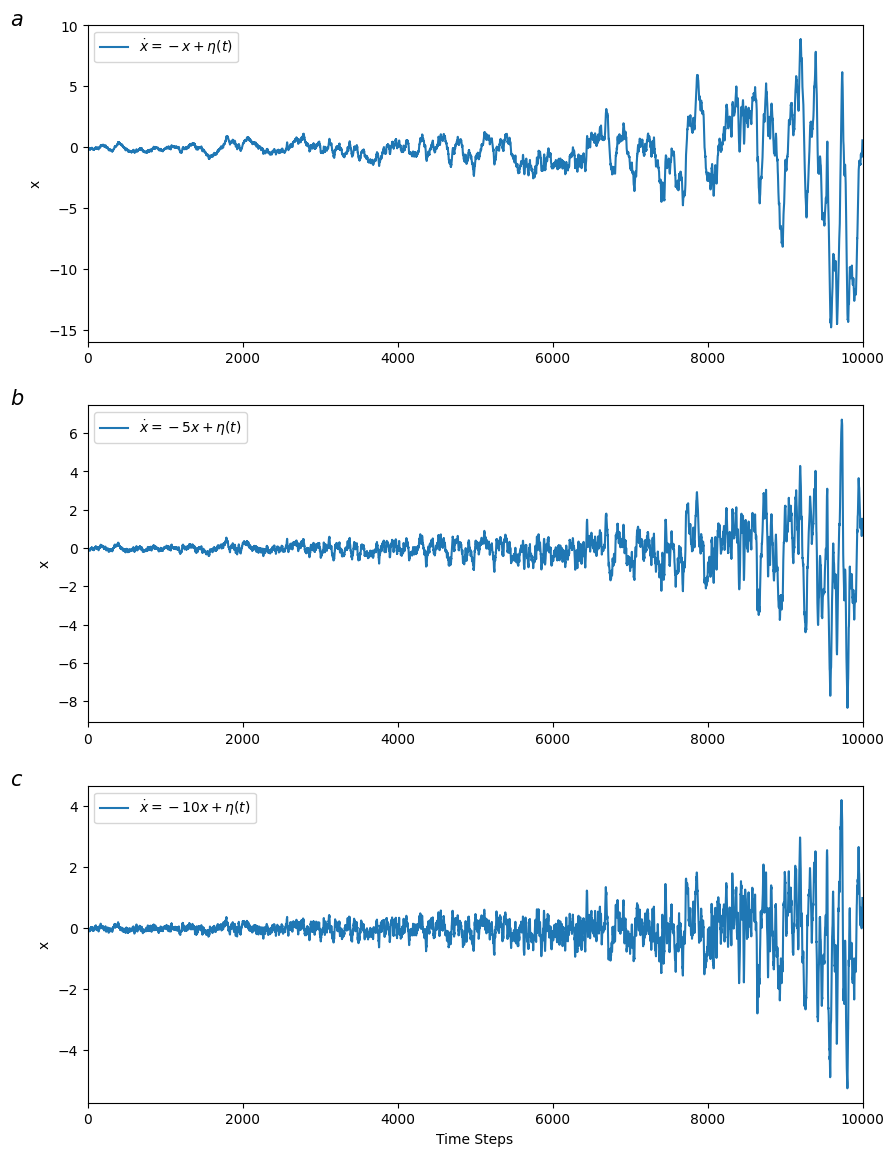

In [132]:
fig = plt.figure(figsize=(10, 14))

ax1 = fig.add_subplot(3, 1, 1)
ax1.text(-1000, 10, '$a$', fontsize=15, weight='bold')
ax1.plot(np.arange(0, n), model_1, label='$\dot{x} = -x + \eta(t)$')
ax1.set_ylabel('x')
ax1.set_xlim(0, n)
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(3, 1, 2)
ax2.text(-1000, 7.5, '$b$', fontsize=15, weight='bold')
ax2.plot(np.arange(0, n), model_5, label='$\dot{x} = -5x + \eta(t)$')
ax2.set_ylabel('x')
ax2.set_xlim(0, n)
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(3, 1, 3)
ax3.text(-1000, 4.7, '$c$', fontsize=15, weight='bold')
ax3.plot(np.arange(0, n), model_10, label='$\dot{x} = -10x + \eta(t)$')
ax3.set_ylabel('x')
ax3.set_xlabel('Time Steps')
ax3.set_xlim(0, n)
ax3.legend(loc='upper left')

In [133]:
fig.savefig(f"plots/model_without_transition_coeff_comparison.pdf")

Text(0, 0.5, 'x')

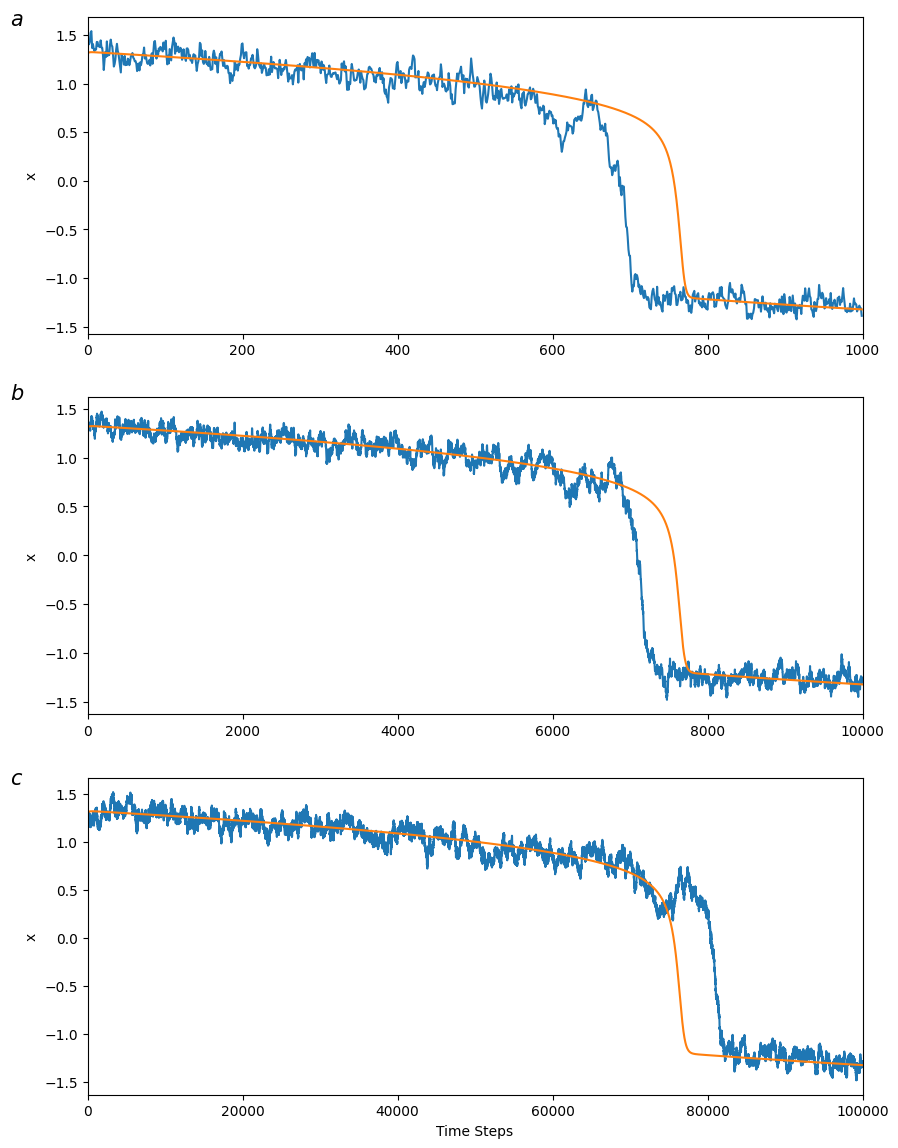

In [128]:
n_1 = int(100 / 0.1)
n_01 = int(100 / 0.01)
n_001 = int(100 / 0.001)

t_1 = np.linspace(0.0, 100, n_1)
t_01 = np.linspace(0.0, 100, n_01)
t_001 = np.linspace(0.0, 100, n_001)

sigma = 0.2
T_1 = 2 * t_1 / 100 - 1
T_01 = 2 * t_01 / 100 - 1
T_001 = 2 * t_001 / 100 - 1

# initialise time series
model1_1 = np.zeros(n_1)
model1_1_noisy = np.zeros(n_1)
model1_01 = np.zeros(n_01)
model1_01_noisy = np.zeros(n_01)
model1_001 = np.zeros(n_001)
model1_001_noisy = np.zeros(n_001)
model1_1[0] = model1_1_noisy[0] = model1_01[0] = model1_01_noisy[0] = model1_001[0] = model1_001_noisy[0] = 1.31 # initial value (close to equilibrium for T = -1)

# Euler-Maruyama method
np.random.seed(0)
for i in range(n_1 - 1):
    model1_1_noisy[i + 1] = model1_1_noisy[i] + 0.1 * (-model1_1_noisy[i]**3 + model1_1_noisy[i] - T_1[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(0.1))
    model1_1[i + 1] = model1_1[i] + 0.1 * (-model1_1[i]**3 + model1_1[i] - T_1[i])

for i in range(n_01 - 1):
    model1_01_noisy[i + 1] = model1_01_noisy[i] + 0.01 * (-model1_01_noisy[i]**3 + model1_01_noisy[i] - T_01[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(0.01))
    model1_01[i + 1] = model1_01[i] + 0.01 * (-model1_01[i]**3 + model1_01[i] - T_01[i])

for i in range(n_001 - 1):
    model1_001_noisy[i + 1] = model1_001_noisy[i] + 0.001 * (-model1_001_noisy[i]**3 + model1_001_noisy[i] - T_001[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(0.001))
    model1_001[i + 1] = model1_001[i] + 0.001 * (-model1_001[i]**3 + model1_001[i] - T_001[i])

    

fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(311)
ax.text(-100, 1.6, '$a$', fontsize=15, weight='bold')
ax.plot(np.arange(0, n_1), model1_1_noisy)
ax.plot(np.arange(0, n_1), model1_1)
ax.set_xlim(0, n_1)
ax.set_ylabel('x')

ax = fig.add_subplot(312)
ax.text(-1000, 1.6, '$b$', fontsize=15, weight='bold')
ax.plot(np.arange(0, n_01), model1_01_noisy)
ax.plot(np.arange(0, n_01), model1_01)
ax.set_xlim(0, n_01)
ax.set_ylabel('x')

ax = fig.add_subplot(313)
ax.text(-10000, 1.6, '$c$', fontsize=15, weight='bold')
ax.plot(np.arange(0, n_001), model1_001_noisy)
ax.plot(np.arange(0, n_001), model1_001)
ax.set_xlim(0, n_001)
ax.set_xlabel('Time Steps')
ax.set_ylabel('x')


In [129]:
fig.savefig(f"plots/model_with_critical_transition_timestep_comparison.pdf")

(0.0, 100000.0)

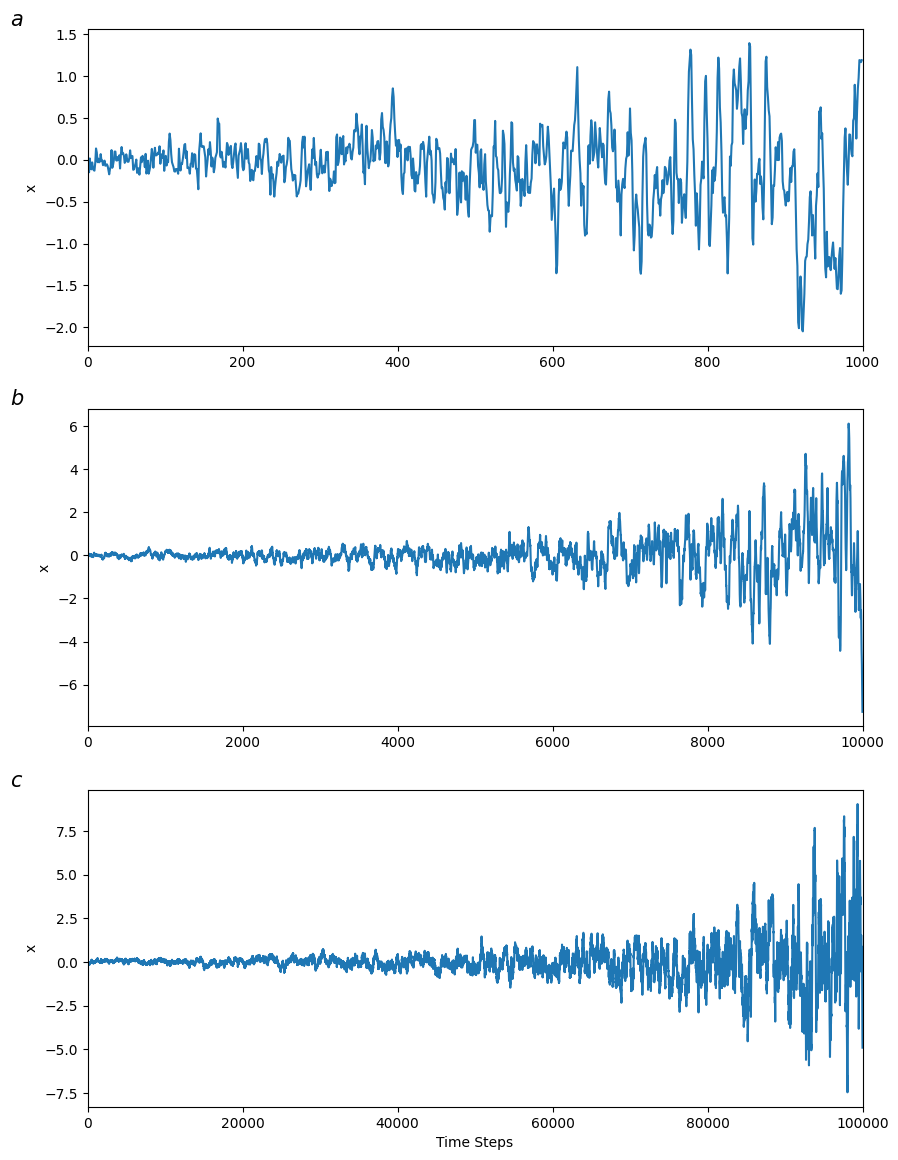

In [130]:
# parameters
sigma_1 = 0.8 * t_1 / 100 + 0.2 
sigma_01 = 0.8 * t_01 / 100 + 0.2 
sigma_001 = 0.8 * t_001 / 100 + 0.2 
phi_1 = 0.85 * t_1 / 100 + 0.1
phi_01 = 0.85 * t_01 / 100 + 0.1
phi_001 = 0.85 * t_001 / 100 + 0.1

np.random.seed(2)
signal_1 = lag1_signal(n_1, phi=phi_1, sigma=0.1)
signal_01 = lag1_signal(n_01, phi=phi_01, sigma=0.01)
signal_001 = lag1_signal(n_001, phi=phi_001, sigma=0.001)

# initialize model
model2_1 = np.zeros(n_1)
model2_01 = np.zeros(n_01)
model2_001 = np.zeros(n_001)
model2_1[0] = signal_1[0]
model2_01[0] = signal_01[0]
model2_001[0] = signal_001[0]

# Euler-Maruyama method
for i in range(n_1 - 1):
    model2_1[i + 1] = model2_1[i] + 0.1 * -5 * model2_1[i] + sigma_1[i] * signal_1[i + 1]
for i in range(n_01 - 1):
    model2_01[i + 1] = model2_01[i] + 0.01 * -5 * model2_01[i] + sigma_01[i] * signal_01[i + 1]
for i in range(n_001 - 1):
    model2_001[i + 1] = model2_001[i] + 0.001 * -5 * model2_001[i] + sigma_001[i] * signal_001[i + 1]
    
fig = plt.figure(figsize=(10,14))

ax = fig.add_subplot(311)
ax.text(-100, 1.6, '$a$', fontsize=15, weight='bold')
ax.plot(np.arange(0, n_1), model2_1)
ax.set_ylabel('x')
ax.set_xlim(0, n_1)

ax = fig.add_subplot(312)
ax.text(-1000, 7, '$b$', fontsize=15, weight='bold')
ax.plot(np.arange(0, n_01), model2_01)
ax.set_ylabel('x')
ax.set_xlim(0, n_01)

ax = fig.add_subplot(313)
ax.text(-10000, 10, '$c$', fontsize=15, weight='bold')
ax.plot(np.arange(0, n_001), model2_001)
ax.set_xlabel('Time Steps')
ax.set_ylabel('x')
ax.set_xlim(0, n_001)

In [131]:
fig.savefig(f"plots/model_without_transition_timestep_comparison.pdf")